In [40]:
import pandas as pd
import numpy as np

V druhom datasete budeme využívať tabuľku game, a game_goalie_stats.

In [28]:
gameInput = pd.read_csv("nhl-game-data/game.csv")
goalieInput = pd.read_csv("nhl-game-data/game_goalie_stats.csv")

In [8]:
goalieInput.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24646 entries, 0 to 24645
Data columns (total 19 columns):
game_id                       24646 non-null int64
player_id                     24646 non-null int64
team_id                       24646 non-null int64
timeOnIce                     24646 non-null int64
assists                       24646 non-null int64
goals                         24646 non-null int64
pim                           24646 non-null int64
shots                         24646 non-null int64
saves                         24646 non-null int64
powerPlaySaves                24646 non-null int64
shortHandedSaves              24646 non-null int64
evenSaves                     24646 non-null int64
shortHandedShotsAgainst       24646 non-null int64
evenShotsAgainst              24646 non-null int64
powerPlayShotsAgainst         24646 non-null int64
decision                      22868 non-null object
savePercentage                24607 non-null float64
powerPlaySavePercenta

Najskor si znova vyberieme len tie stĺpce ktoré potrebujeme.

In [29]:
gameInput1 = gameInput.loc[:,['game_id', 'season', 'date_time_GMT', 'home_team_id', 'away_team_id', 'date_time', 'away_goals', 'home_goals']]

DataFrame s brankarmi si rovno aj upravime. Vytvorime groupy podľa zápasov a následne podľa tímov. Potom sčítame, všetky hodnoty v skupinách. 

In [30]:
goalies = goalieInput.loc[:,['game_id','team_id','shots','saves']].groupby(['game_id','team_id']).sum().reset_index()

Tak môžeme vypočítať priemernú uspešnosť brankárov v danom zápase.

In [31]:
goalies['percentage'] = (goalies['saves'] / goalies['shots'])
print(type(goalies.loc[goalies['game_id'] == 2010020001]['percentage'].values[0]))

<class 'numpy.float64'>


Následne pre každý zápas zistíme úspešnosť brankárov.

In [32]:
goalies1 = pd.DataFrame(columns=['game_id', 'home_percentage', 'away_percentage'])
for index, row in gameInput1.iterrows():
    if not goalies.loc[(goalies['game_id'] == row['game_id']) & (goalies['team_id'] == row['away_team_id'])].empty:
        awayPerc = goalies.loc[(goalies['game_id'] == row['game_id']) & (goalies['team_id'] == row['away_team_id'])]
    if not goalies.loc[(goalies['game_id'] == row['game_id']) & (goalies['team_id'] == row['home_team_id'])].empty:
        homePerc = goalies.loc[(goalies['game_id'] == row['game_id']) & (goalies['team_id'] == row['home_team_id'])]
    d = {'game_id': row['game_id'], 'home_percentage': homePerc['percentage'].values[0], 'away_percentage': awayPerc['percentage'].values[0]}
    goalies1.at[index, :] = d
goalies1

,game_id,home_percentage,away_percentage
0,2.01103e+09,0.884615,0.888889
1,2.01103e+09,0.911765,0.95
2,2.01103e+09,0.892857,0.870968
3,2.01103e+09,0.909091,0.928571
4,2.01103e+09,0.9,0.964286
...,...,...,...
11429,2.01803e+09,0.73913,0.931034
11430,2.01803e+09,0.913043,0.918919
11431,2.01803e+09,0.904762,0.974359
11432,2.01803e+09,0.870968,0.965517


Teraz spojíme tabuľky game a goalies.

In [33]:
gameInput1 = gameInput1.join(goalies1, lsuffix='', rsuffix='_goalie')

In [34]:
gameInput1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11434 entries, 0 to 11433
Data columns (total 11 columns):
game_id            11434 non-null int64
season             11434 non-null int64
date_time_GMT      11434 non-null object
home_team_id       11434 non-null int64
away_team_id       11434 non-null int64
date_time          11434 non-null object
away_goals         11434 non-null int64
home_goals         11434 non-null int64
game_id_goalie     11434 non-null object
home_percentage    11434 non-null object
away_percentage    11434 non-null object
dtypes: int64(6), object(5)
memory usage: 982.7+ KB


Teraz si upravíme úspešnosť brankárov na numerickú hodnotu, aby sme mohli počítať priemer aj z tejto hodnoty.

In [35]:
gameAwayValues = gameInput1.assign(away_percentage=pd.to_numeric(gameInput1['away_percentage'], errors='coerce'))\
    .loc[:,['away_team_id', 'away_goals', 'home_goals', 'away_percentage', 'season']].groupby(['away_team_id', 'season'])\
    .mean().reset_index()
gameHomeValues = gameInput1.assign(home_percentage=pd.to_numeric(gameInput1['home_percentage'], errors='coerce'))\
    .loc[:,['home_team_id', 'away_goals', 'home_goals', 'home_percentage', 'season']].groupby(['home_team_id', 'season'])\
    .mean().reset_index()
# gameAwayValues
gameHomeValues


,home_team_id,season,away_goals,home_goals,home_percentage
0,1,20102011,2.463415,2.292683,0.898303
1,1,20112012,2.461538,2.846154,0.906777
2,1,20122013,2.458333,2.750000,0.892649
3,1,20132014,2.243902,2.560976,0.916448
4,1,20142015,2.195122,2.219512,0.931411
...,...,...,...,...,...
267,53,20162017,2.853659,2.536585,0.918366
268,53,20172018,2.878049,2.487805,0.914878
269,53,20182019,2.463415,2.707317,0.922345
270,54,20172018,2.470588,3.588235,0.917683


Vytvoríme si dataFrame s potrebnými atribútmi.

In [36]:
dataSet1 = pd.DataFrame(columns=['game_id','season', 'date_time', 'game1home','game1away', 'game1isHome','game2home', \
                                 'game2away','game2isHome','game3home','game3away','game3isHome','game4home','game4away',\
                                 'game4isHome','game5home','game5away','game5isHome', 'home_perc', 'away_perc','home_team_id', 'away_team_id', \
                                 'home_scored_avg', 'home_conceded_avg', 'away_scored_avg', 'away_conceded_avg', \
                                 'total'])

Nasledujúci kód je plne prispôsobený nášmu riešeniu, a preto sa môže zdať, že je neprehľadný. 

Pre každý zápas najskôr nájdeme priemerné počty gólov v domácich alebo hosťujúcich zápasoch v minulých sezónach. S týmti zároveň nájdeme aj percentuálnu úspešnosť brankárov v týchto sezónach. Vytvoríme si objekt.  

Následne nájdeme pre tieto dva tímy posledných 5 spoločných zápasov, a z nich vyberieme počet gólov domácich a hostí. Dynamicky ich priradíme do objektu d. Zároveň, domáci tím nemusí byť v predchádzajúcich zápasoch ako domáci tím, tak musíme zaznamenať, či bol ako domáci tím aj v týchto zápasoch. Pri každom zápase je flag gameXisHome. Nakoniec ich uložíme do dataSet1.

In [37]:
gameAwayValues = gameAwayValues.dropna()
gameHomeValues = gameHomeValues.dropna()
for index, row in gameInput1.iterrows():
    season = row['season'] - 10001
    if not gameAwayValues.loc[(gameAwayValues['away_team_id'] == row['away_team_id']) & (gameAwayValues['season'] == season)].empty:
        if not gameHomeValues.loc[(gameHomeValues['home_team_id'] == row['home_team_id']) & (gameHomeValues['season'] == season)].empty:
            awayTeam = gameAwayValues.loc[(gameAwayValues['away_team_id'] == row['away_team_id']) & (gameAwayValues['season'] == season)]
            homeTeam = gameHomeValues.loc[(gameHomeValues['home_team_id'] == row['home_team_id']) & (gameHomeValues['season'] == season)]
#             print(homeTeam, awayTeam)
            d = {'game_id': row['game_id'],\
                 'season': row['season'],\
                 'date_time': row['date_time'],\
                 'home_team_id': row['home_team_id'], \
                 'home_perc': homeTeam['home_percentage'].values[0], \
                 'away_perc': awayTeam['away_percentage'].values[0], \
                 'home_scored_avg': homeTeam['home_goals'].values[0], \
                 'home_conceded_avg': homeTeam['away_goals'].values[0], \
                 'away_team_id': row['away_team_id'], \
                 'away_scored_avg': awayTeam['away_goals'].values[0], \
                 'away_conceded_avg': awayTeam['home_goals'].values[0], \
                 'total': row['home_goals'] + row['away_goals']}
            for i in range(1,6):
                d['game' + str(i) + 'home'] = 0
                d['game' + str(i) + 'away'] = 0
                d['game' + str(i) + 'isHome'] = 1
            if not gameInput.loc[((gameInput['date_time_GMT'] < row['date_time_GMT']) & \
                                  ((gameInput['home_team_id'] == row['home_team_id']) & \
                                  (gameInput['away_team_id'] == row['away_team_id'])) | \
                                  ((gameInput['home_team_id'] == row['away_team_id']) & \
                                  (gameInput['away_team_id'] == row['home_team_id'])))].tail(5).empty:
                previousGames = gameInput.loc[((gameInput['date_time_GMT'] < row['date_time_GMT']) & \
                                  ((gameInput['home_team_id'] == row['home_team_id']) & \
                                  (gameInput['away_team_id'] == row['away_team_id'])) | \
                                  ((gameInput['home_team_id'] == row['away_team_id']) & \
                                  (gameInput['away_team_id'] == row['home_team_id'])))].tail(5)
                i = 1
                for index1, row1 in previousGames.iterrows():
                    if (row1.home_team_id == row.home_team_id):
                        d['game' + str(i) + 'home'] = row1['home_goals']
                        d['game' + str(i) + 'away'] = row1['away_goals']
                        d['game' + str(i) + 'isHome'] = 1
                    else:
                        d['game' + str(i) + 'home'] = row1['away_goals']
                        d['game' + str(i) + 'away'] = row1['home_goals']
                        d['game' + str(i) + 'isHome'] = 0
                    i += 1
                    
            dataSet1.at[index, :] = d

In [56]:
dataSet1 = dataSet1.sort_values(by=['date_time'])
dataSet1

,game_id,season,date_time,game1home,game1away,game1isHome,game2home,game2away,game2isHome,game3home,...,game5isHome,home_perc,away_perc,home_team_id,away_team_id,home_scored_avg,home_conceded_avg,away_scored_avg,away_conceded_avg,total
11049,2011020002,20112012,2011-10-06,0,2,0,1,4,0,5,...,0,0.908803,0.917199,10,8,2.68293,2.90244,2.48889,2.62222,2
9192,2011020001,20112012,2011-10-06,1,2,1,3,0,0,2,...,0,0.93641,0.910287,6,4,3.14815,2.16667,3.04348,2.84783,3
10104,2011020007,20112012,2011-10-07,0,1,0,3,1,0,4,...,1,0.914468,0.908225,7,24,2.97727,2.72727,2.79545,3.09091,5
11113,2011020004,20112012,2011-10-07,4,3,0,1,5,0,2,...,1,0.913319,0.904372,12,14,3.07317,2.78049,2.78431,2.96078,6
10684,2011020009,20112012,2011-10-07,2,3,0,2,4,0,5,...,0,0.905153,0.924993,26,3,2.77273,2.54545,2.45455,2.36364,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429,2018030413,20182019,2019-06-02,2,4,1,2,4,0,3,...,0,0.909999,0.914906,19,6,2.80488,2.53659,2.91489,2.70213,9
11430,2018030414,20182019,2019-06-04,2,4,0,3,2,0,2,...,0,0.909999,0.914906,19,6,2.80488,2.53659,2.91489,2.70213,6
11431,2018030415,20182019,2019-06-07,4,2,1,2,3,1,7,...,0,0.908886,0.912837,6,19,3.70213,2.6383,2.70732,2.87805,3
11432,2018030416,20182019,2019-06-10,3,2,0,2,7,1,4,...,0,0.909999,0.914906,19,6,2.80488,2.53659,2.91489,2.70213,6


Uložíme si tento dataFrame.

In [39]:
dataSet1.to_csv('.\datasets\dataFrameGameGoalies.csv', encoding='utf-8', index=False)

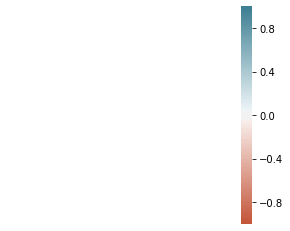

Vymažeme nepotrebné stĺpce

In [57]:
dataSetFinal = dataSet1.drop('date_time',1)

Teraz si rozdelíme dataFrame na 2 množiny. Znova podľa sezón.

In [58]:
dataTrain1 = dataSetFinal.loc[dataSetFinal.season != 20182019]
dataTest1 = dataSetFinal.loc[dataSetFinal.season != 20182019]

Následne tieto množiny rozdelíme na vstupné vektory a očakávané hodnoty. 

In [60]:
dataSet2TrainX = dataTrain1.drop('season',1).drop('game_id',1).drop('total',1)
dataSet2TrainY = dataTrain1.total
dataSet2TestX = dataTest1.drop('season',1).drop('game_id',1).drop('total',1)
dataSet2TestY = dataTest1.total

In [61]:
dataSet2TrainX

,game1home,game1away,game1isHome,game2home,game2away,game2isHome,game3home,game3away,game3isHome,game4home,...,game5away,game5isHome,home_perc,away_perc,home_team_id,away_team_id,home_scored_avg,home_conceded_avg,away_scored_avg,away_conceded_avg
11049,0,2,0,1,4,0,5,4,0,3,...,6,0,0.908803,0.917199,10,8,2.68293,2.90244,2.48889,2.62222
9192,1,2,1,3,0,0,2,1,0,6,...,5,0,0.93641,0.910287,6,4,3.14815,2.16667,3.04348,2.84783
10104,0,1,0,3,1,0,4,2,0,2,...,2,1,0.914468,0.908225,7,24,2.97727,2.72727,2.79545,3.09091
11113,4,3,0,1,5,0,2,4,1,3,...,6,1,0.913319,0.904372,12,14,3.07317,2.78049,2.78431,2.96078
10684,2,3,0,2,4,0,5,4,0,4,...,4,0,0.905153,0.924993,26,3,2.77273,2.54545,2.45455,2.36364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,6,5,1,0,1,1,3,4,0,3,...,3,0,0.932634,0.917073,15,14,3.125,1.83333,2.58537,2.65854
634,6,5,1,0,1,1,3,4,0,3,...,3,0,0.932634,0.917073,15,14,3.125,1.83333,2.58537,2.65854
635,3,0,1,5,6,0,1,0,0,4,...,4,0,0.902329,0.909422,14,15,3.12195,2.87805,3.17021,2.76596
636,6,5,1,0,1,1,3,4,0,3,...,3,0,0.932634,0.917073,15,14,3.125,1.83333,2.58537,2.65854


In [62]:
dataSet2TrainY

11049    2
9192     3
10104    5
11113    6
10684    5
        ..
633      6
634      6
635      5
636      3
637      4
Name: total, Length: 8491, dtype: object

Tieto množiny uložíme do .csv súborov.

In [63]:
dataSet2TrainX.to_csv('.\datasets\dataSet2TrainX.csv', encoding='utf-8', index=False)
dataSet2TrainY.to_csv('.\datasets\dataSet2TrainY.csv', encoding='utf-8',index=False)
dataSet2TestX.to_csv('.\datasets\dataSet2TestX.csv', encoding='utf-8', index=False)
dataSet2TestY.to_csv('.\datasets\dataSet2TestY.csv', encoding='utf-8', index=False)

C:\Users\Filip\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
C:\Users\Filip\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
